# By using VGG19

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import the libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses, metrics
import matplotlib.pyplot as plt

# Create training and validation dataset

Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.


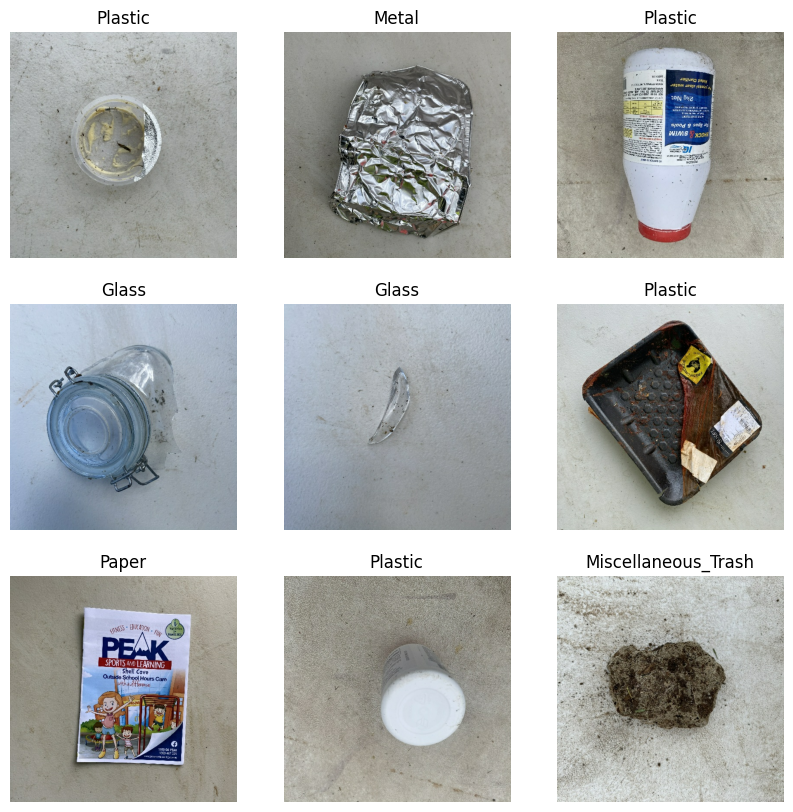

In [3]:
epochs=10
batch_size = 32
img_height = 524
img_width = 524

data_dir = '/content/drive/MyDrive/Dataset_real_waste/realwaste-main/RealWaste'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
)

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

# Load the Vgg19 model

Set the trainable of VGG19 model as False and only train Dense layers.

In [4]:
pretrained_vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(524, 524, 3), weights='imagenet')
pretrained_vgg.trainable = False

for layer in pretrained_vgg.layers:
  layer.trainable = False

pretrained_vgg.summary()

inputs = layers.Input((524, 524, 3), batch_size)
x = tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg19.preprocess_input(x))(inputs)
x = pretrained_vgg(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation='softmax')(x)

vgg_model = Model(inputs, outputs)
vgg_model.compile(optimizer=optimizers.Adamax(learning_rate=1e-4), loss=losses.CategoricalCrossentropy(), metrics=[metrics.F1Score(average='micro')])

vgg_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 524, 524, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 524, 524, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 524, 524, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 262, 262, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 262, 262, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 262, 262, 128)     147584    
                                                              

# Training VGG19 model

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_model/tf_vgg.keras', save_best_only=True, verbose=1)
history = vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 4.4247 - f1_score: 0.5000
Epoch 1: val_loss improved from inf to 1.07843, saving model to /content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_model/tf_vgg.keras
119/119 [==============================] - 234s 2s/step - loss: 4.4247 - f1_score: 0.5000 - val_loss: 1.0784 - val_f1_score: 0.6979
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 0.6716 - f1_score: 0.7948
Epoch 2: val_loss improved from 1.07843 to 0.97503, saving model to /content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_model/tf_vgg.keras
119/119 [==============================] - 176s 1s/step - loss: 0.6716 - f1_score: 0.7948 - val_loss: 0.9750 - val_f1_score: 0.7221
Epoch 3/10
119/119 [==============================] - ETA: 0s - loss: 0.3565 - f1_score: 0.8843
Epoch 3: val_loss did not improve from 0.97503
119/119 [==============================] - 156s 1s/step - loss: 0.3565 - f1_score: 0.8843 - val_loss: 0.9

In [5]:
vgg_model.load_weights('/content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_model/tf_vgg.keras')

In [6]:
pretrained_vgg.trainable = True

In [7]:
print("Number of layers in the base model: ", len(pretrained_vgg.layers))

fine_tune_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_vgg.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  22


In [8]:
vgg_model.compile(optimizer=optimizers.Adamax(learning_rate=1e-5), loss=losses.CategoricalCrossentropy(), metrics=[metrics.F1Score(average='micro')])

In [9]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 524, 524, 3)]       0         
                                                                 
 lambda (Lambda)             (32, 524, 524, 3)         0         
                                                                 
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 flatten (Flatten)           (32, 131072)              0         
                                                                 
 dense (Dense)               (32, 512)                 67109376  
                                                                 
 dropout (Dropout)           (32, 512)                 0         
                                                                 
 dense_1 (Dense)             (32, 9)                   4617  

In [11]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_model/tf_vgg_finetune.keras', save_best_only=True, verbose=1)

history_fine = vgg_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds, callbacks=[cp_callback]
)

Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 0.0815 - f1_score: 0.9726
Epoch 1: val_loss improved from inf to 0.87053, saving model to /content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_model/tf_vgg_finetune.keras
119/119 [==============================] - 1003s 8s/step - loss: 0.0815 - f1_score: 0.9726 - val_loss: 0.8705 - val_f1_score: 0.7747
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 0.0601 - f1_score: 0.9816
Epoch 2: val_loss improved from 0.87053 to 0.85535, saving model to /content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_model/tf_vgg_finetune.keras
119/119 [==============================] - 202s 2s/step - loss: 0.0601 - f1_score: 0.9816 - val_loss: 0.8553 - val_f1_score: 0.7937
Epoch 3/10
119/119 [==============================] - ETA: 0s - loss: 0.0572 - f1_score: 0.9808
Epoch 3: val_loss improved from 0.85535 to 0.83155, saving model to /content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_mo

# Plotting training and validation loss vs epoch

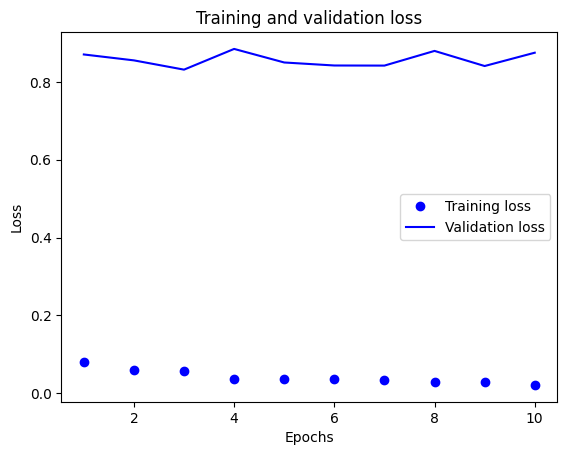

In [13]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']  # If you have validation data

# Plot loss vs epoch graph
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # If you have validation data
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix of VGG19

In [4]:
import numpy as np

In [5]:
vgg_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset_real_waste/realwaste-main/saved_model/tf_vgg_finetune.keras', safe_mode=False)

In [6]:
from types import NoneType
X_test = None
y_test = None

for x, y in val_ds:
  if type(X_test) == NoneType:
    X_test = x
    y_test = y
  else:
    X_test = np.concatenate((X_test, x))
    y_test = np.concatenate((y_test, y))

In [7]:
predicted_labels = vgg_model.predict(X_test)

30/30 [==============================] - 74s 2s/step


In [8]:
predicted_labels = np.argmax(predicted_labels, axis=1)

In [9]:
true_labels = np.argmax(y_test, axis=1)

In [10]:
true_labels.shape, predicted_labels.shape

((950,), (950,))

In [12]:
from sklearn.metrics import f1_score

f1_score(true_labels, predicted_labels, average='micro')

0.7905263157894736

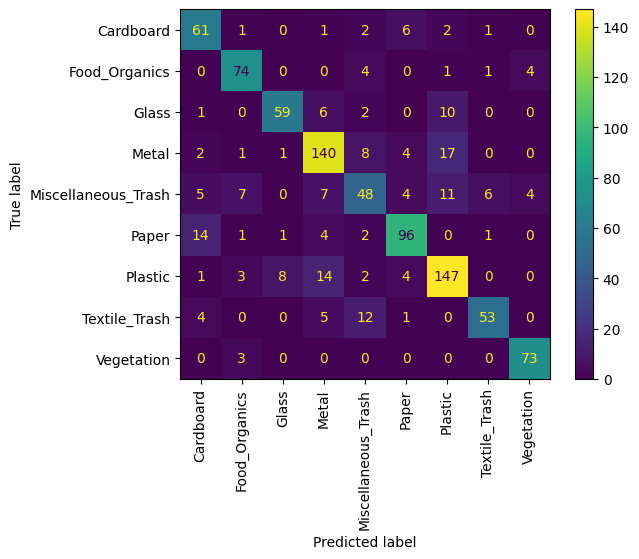

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', display_labels=val_ds.class_names)